In [1]:
import abc
from collections import *
from dataclasses import dataclass
import enum
import gym
import heapq
import numpy as np
from typing import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class Agent(abc.ABC):
    
    @abc.abstractmethod
    def get_action(self, env, state):
        pass


def try_agent(agent: Agent):
    with gym.make("CartPole-v0") as env:
        total_reward = 0.0
        obs = env.reset()
        env.render()
        done = False
        while not done:
            action = agent.get_action(env, obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            env.render()
        print("Total reward {0:.2f}".format(total_reward))

In [3]:
"""
Random agent
"""

class RandomAgent(Agent):
    def get_action(self, env, state):
        return env.action_space.sample()


try_agent(RandomAgent())

Total reward 18.00


In [4]:
"""
Manual agent (does not take account of speed)
"""


class BrutalAgent(Agent):
    def get_action(self, env, state):
        x, x_dot, theta, theta_dot = state
        if theta < 0.02:
            return 0
        elif theta > 0.02:
            return 1
        return 0


try_agent(BrutalAgent())

Total reward 29.00


In [5]:
"""
Application of PID circuit (limited to linear systems)
"""


# How you do it in the industry

'\nApplication of PID circuit (limited to linear systems)\n'

In [6]:
"""
Cross Entropy Method:
- Start with a random policy
- Play N episodes with the current policy
- Take the episodes above a reward boundary (typically percentile 70th)
- Train on these "Elite" episodes (throw away the uninteresting ones)
=> Look like a kind of genetic algorithm stuff
"""


Episode = namedtuple('Episode', 'states actions score')


class Policy(abc.ABC):
    def get_action(self, state) -> 'action':
        pass
    
    def improve(self, episodes: List[Episode]):
        pass
    

class CrossEntropyAgent(Agent):
    def __init__(self, policy: Policy):
        self.policy = policy
    
    def get_action(self, env, state):
        return self.policy.get_action(state)
    
    def fit(self, env, max_iteration: int = 100, batch_size: int = 1000, batch_threshold: float = 0.7) -> List[float]:
        mean_scores = []
        for _ in range(max_iteration):
            episodes = [self._play_episode(env) for _ in range(batch_size)]
            mean_score = np.mean([episode.score for episode in episodes])
            mean_scores.append(mean_score)
            print("Mean score:", mean_score)
            if mean_score >= 200:
                print("Solved!")
                break
            
            episodes.sort(key=lambda episode: episode.score)
            episodes = episodes[int(batch_threshold*batch_size):]
            self.policy.improve(episodes)
        return mean_scores
    
    def _play_episode(self, env) -> List[Episode]:
        states, actions = [], []
        total_reward = 0.0
        state = env.reset()
        done = False
        while not done:
            action = self.get_action(env, state)
            states.append(state)
            actions.append(action)
            state, reward, done, _ = env.step(action)
            total_reward += reward
        return Episode(states, actions, total_reward)

Mean score: 18.875
Mean score: 37.0
Mean score: 56.0
Mean score: 52.4375
Mean score: 50.5625
Mean score: 51.3125
Mean score: 51.25
Mean score: 51.375
Mean score: 84.125
Mean score: 83.4375
Mean score: 81.5625
Mean score: 78.0625
Mean score: 80.75
Mean score: 61.9375
Mean score: 69.25
Mean score: 66.875
Mean score: 96.0625
Mean score: 109.375
Mean score: 99.5
Mean score: 134.8125
Mean score: 134.75
Mean score: 115.875
Mean score: 151.8125
Mean score: 167.0
Mean score: 180.125
Mean score: 196.1875
Mean score: 196.6875
Mean score: 188.5625
Mean score: 200.0
Solved!


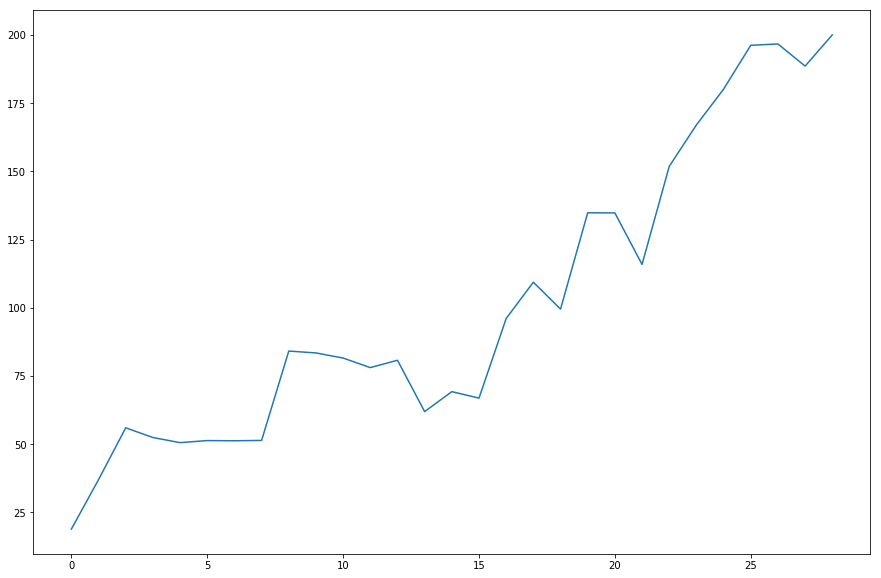

In [16]:
"""
Implementation of a policy to learn via a Neural Net
"""


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


class FullyConnectedNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax = False):
        ys = self.fc(observations)
        if with_softmax:
            return self.softmax(ys)
        return ys


class NeuralNetPolicy(Policy):
    def __init__(self, iteration_nb: int, learning_rate: float, net: nn.Module):
        self.net = net
        self.iteration_nb = iteration_nb
        self.learning_rate = learning_rate
    
    def get_action(self, state) -> 'action':
        self.net.eval()
        xs = torch.FloatTensor(state)
        ys = self.net(xs, with_softmax=True)
        probabilities = ys.detach().numpy()
        action = np.random.choice(len(probabilities), p=probabilities)
        return action
    
    def improve(self, episodes: List[Episode]):
        self.net.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate)
        data_set = self._to_data_set(episodes)
        loader = data.DataLoader(data_set, batch_size=100, shuffle=True)
        for _ in range(self.iteration_nb):
            for states, actions in loader:
                optimizer.zero_grad()
                got = self.net(states, with_softmax=False)
                loss = criterion(got, actions)
                loss.backward()
                optimizer.step()

    def _to_data_set(self, episodes: List[Episode]):
        xs, ys = [], []
        for episode in episodes:
            for state, action in zip(episode.states, episode.actions):
                xs.append(state)
                ys.append(action)
        xs = torch.FloatTensor(xs)
        ys = torch.LongTensor(ys)
        return data.TensorDataset(xs, ys)

    
"""
Test with the policy of a neural net
"""


fc_net = FullyConnectedNet(observation_size=4, hidden_size=100, action_size=2)
policy = NeuralNetPolicy(iteration_nb=5, learning_rate=0.1, net=fc_net)
agent = CrossEntropyAgent(policy)
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

Mean score: 23.375
Mean score: 32.6875
Mean score: 39.125
Mean score: 57.1875
Mean score: 68.6875
Mean score: 101.375
Mean score: 139.4375
Mean score: 142.8125
Mean score: 163.75
Mean score: 189.5
Mean score: 196.875
Mean score: 199.9375
Mean score: 200.0
Solved!


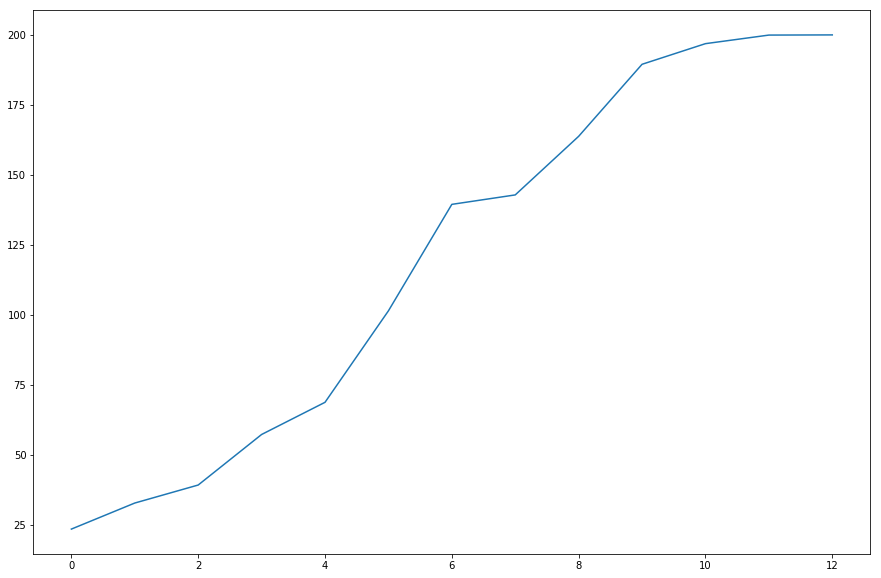

In [22]:
class PolynomialRegressionNet(nn.Module):
    def __init__(self, observation_size, action_size):
        super().__init__()
        feature_size = self._transform(torch.zeros(observation_size)).shape[0]
        self.fc = nn.Linear(feature_size, action_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax=False):
        if len(observations.shape) == 2:
            xs = torch.stack([self._transform(observation) for observation in observations])
        else:
            xs = self._transform(observations)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys)
        return ys
    
    def _transform(self, observation):
        xs = list(observation)
        k = len(observation)
        for i in range(k-1):
            for j in range(i+1, k):
                xs.append(observation[i] * observation[j])
        return torch.FloatTensor(xs)
    

"""
Test with the policy of a neural net
"""


fc_net = PolynomialRegressionNet(observation_size=4, action_size=2)
policy = NeuralNetPolicy(iteration_nb=5, learning_rate=0.1, net=fc_net)
agent = CrossEntropyAgent(policy)
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

# 1000 Mean score: 13.169 (epsilon: 0.5 )
# 2000 Mean score: 13.06 (epsilon: 0.46 )
# 3000 Mean score: 12.66 (epsilon: 0.42000000000000004 )
# 4000 Mean score: 13.134 (epsilon: 0.38000000000000006 )
# 5000 Mean score: 21.415 (epsilon: 0.3400000000000001 )
# 6000 Mean score: 77.521 (epsilon: 0.3000000000000001 )
# 7000 Mean score: 78.998 (epsilon: 0.2600000000000001 )
# 8000 Mean score: 118.362 (epsilon: 0.2200000000000001 )
# 9000 Mean score: 157.331 (epsilon: 0.1800000000000001 )
# 10000 Mean score: 87.064 (epsilon: 0.1400000000000001 )
# 11000 Mean score: 131.167 (epsilon: 0.10000000000000009 )
# 12000 Mean score: 123.467 (epsilon: 0.1 )
# 13000 Mean score: 60.378 (epsilon: 0.1 )
# 14000 Mean score: 184.33 (epsilon: 0.1 )
# 15000 Mean score: 150.995 (epsilon: 0.1 )
# 16000 Mean score: 83.874 (epsilon: 0.1 )
# 17000 Mean score: 200.0 (epsilon: 0.1 )


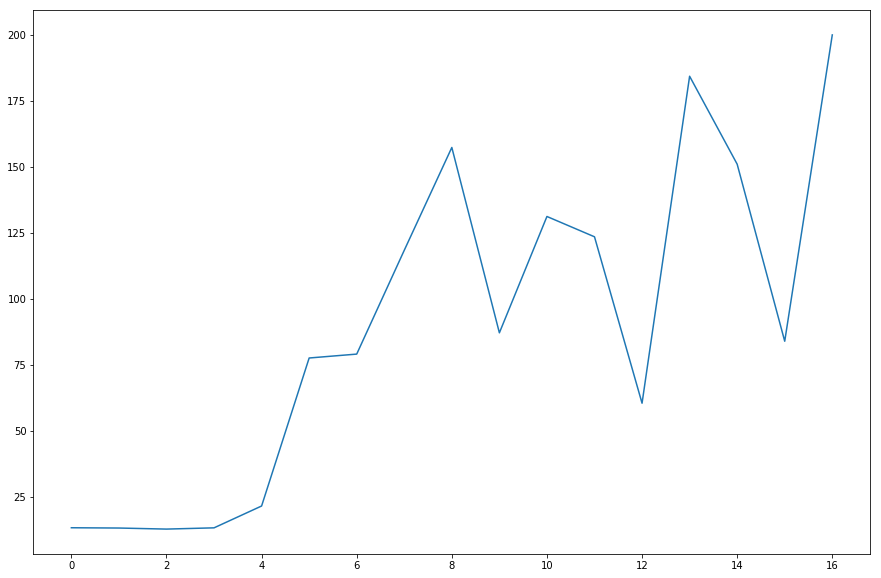

In [60]:
"""
With Deep Q-Learning
"""


Experience = namedtuple('Experience', 'state action next_state reward done')
ExperienceBatch = namedtuple('ExperienceBatch', 'states actions next_states rewards dones')


class Experiences:
    def __init__(self, size: int):
        self.buffer = deque(maxlen=size)
    
    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)
    
    def extend(self, experiences: List[Experience]):
        for experience in experiences:
            self.append(experience)
    
    def sample(self, batch_size: int):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, next_states, rewards, dones = zip(*[self.buffer[idx] for idx in indices])
        return ExperienceBatch(
            states=np.array(states),
            actions=np.array(actions),
            next_states=np.array(next_states),
            rewards=np.array(rewards, dtype=np.float32),
            dones=np.array(dones, dtype=np.uint8))


class RegressionNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))
        
    def forward(self, observations):
        ys = self.fc(observations)
        return ys

    
class NeuralNetQValues:
    def __init__(self, iteration_nb: int, learning_rate: float, reward_discount: float = 1.):
        self.net = RegressionNet(observation_size=4, hidden_size=100, action_size=2)
        self.target_net = RegressionNet(observation_size=4, hidden_size=100, action_size=2)
        self.iteration_nb = iteration_nb
        self.reward_discount = reward_discount
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
    
    def best_action(self, state) -> 'action':
        self.net.eval()
        xs = torch.FloatTensor(state)
        ys = self.target_net(xs)
        return torch.argmax(ys, dim=-1).detach().numpy()
    
    def improve_valuation(self, experiences: ExperienceBatch):
        self.net.eval()
        states = torch.FloatTensor(experiences.states)
        actions = torch.LongTensor(experiences.actions)
        next_states = torch.FloatTensor(experiences.next_states)
        rewards = torch.FloatTensor(experiences.rewards)
        dones = torch.ByteTensor(experiences.dones)
        next_values = self.target_net(next_states).max(dim=-1)[0]
        next_values[dones] = 0.0 # Set all values of terminal states to zero
        expected_values = next_values * self.reward_discount + rewards
        
        self.net.train()
        self.optimizer.zero_grad()
        current_values = self._gather_action_values(self.net(states), actions)
        loss = self.criterion(current_values, expected_values)
        loss.backward()
        self.optimizer.step()
    
    def improve_policy(self):
        self.target_net.load_state_dict(self.net.state_dict())

    def _gather_action_values(self, out_values, actions):
        action_indices = actions.unsqueeze(dim=-1)
        values = torch.gather(out_values, dim=-1, index=action_indices)
        return values.squeeze(dim=-1)
    

class DeepQLearningAgent(Agent):
    def __init__(self, q_values: NeuralNetQValues, start_epsilon: float = 0.1, min_epsilon: float = 0.0):
        self.q_values = q_values
        self.epsilon = start_epsilon
        self.min_epsilon = min_epsilon
    
    def get_action(self, env, state):
        if self.epsilon > 0. and np.random.random() < self.epsilon:
            return env.action_space.sample()
        return self.q_values.best_action(state)
    
    def fit(self, env,
            max_episodes: int = 100_000,
            replay_buffer_size: int = 2_000,
            replay_start_size: int = 1_000,
            batch_size: int = 100,
            policy_improvement_size: int = 1_000,
            epsilon_decrease: float = 0.) -> List[float]:

        experiences = Experiences(replay_buffer_size)
        mean_scores = []
        scores = deque(maxlen=policy_improvement_size)
        
        for episode_id in range(1, max_episodes):
            episode_experiences, episode_score = self._play_episode(env)
            experiences.extend(episode_experiences)
            scores.append(episode_score)
            
            if len(experiences) >= replay_start_size:
                self.q_values.improve_valuation(experiences.sample(batch_size))
            
            if episode_id % policy_improvement_size == 0:
                mean_scores.append(sum(scores) / len(scores))
                print("#", episode_id, "Mean score:", mean_scores[-1], "(epsilon:", self.epsilon, ")")
                if mean_scores[-1] >= 200:
                    break
                
                self.q_values.improve_policy()
                self.epsilon = max(self.min_epsilon, self.epsilon - epsilon_decrease)
    
        return mean_scores
    
    def _play_episode(self, env):
        experiences = []
        total_reward = 0.0
        state = env.reset()
        done = False
        while not done:
            action = self.get_action(env, state)
            next_state, reward, done, _ = env.step(action)
            experiences.append(Experience(state, action, next_state, reward, done))
            total_reward += reward
            state = next_state
        return experiences, total_reward
    
    
"""
Try the Deep Q learning agent
"""


start_epsilon = 0.5
end_epsilon = 0.1

agent = DeepQLearningAgent(
    q_values=NeuralNetQValues(iteration_nb=100, learning_rate=1e-2),
    start_epsilon=start_epsilon,
    min_epsilon=end_epsilon)

with gym.make("CartPole-v0") as env:
    max_iterations = 100
    scores = agent.fit(env,
                       max_episodes = 50_000,
                       replay_buffer_size = 2_000,
                       replay_start_size = 1_000,
                       batch_size = 100,
                       policy_improvement_size = 1_000,
                       epsilon_decrease = (start_epsilon - end_epsilon) / 10)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()